In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import anndata as ad
import os

sc.settings.verbosity = 3

## Filter and combine

In [2]:
data_dir = "./data/raw/"
h5_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".h5")]
len(h5_files)

13

In [ ]:
for ix, h5_file in enumerate(h5_files):
    print(f"Processing file {ix + 1}/{len(h5_files)}: {h5_file}")

    adata = sc.read_10x_h5(h5_file)

    adata.var_names_make_unique()

    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_cells(adata, max_genes=7000)
    sc.pp.filter_genes(adata, min_cells=3)

    # individual scrublet score
    # https://discourse.scverse.org/t/how-to-concatenate-anndata-properly/887
    sc.pp.scrublet(adata)

    # store the filtered data
    filtered_dir = "./data/filtered/"

    # maybe perform Mt25 removal here
    
    # write as h5ad with basename
    basename = os.path.basename(h5_file)
    basename = os.path.splitext(basename)[0]
    filtered_file = os.path.join(filtered_dir, f"{basename}_filtered.h5ad")
    adata.write_h5ad(filtered_file)


In [4]:
filtered_data_dir = "./data/filtered"
filtered_h5_files = [os.path.join(filtered_data_dir, f) for f in os.listdir(filtered_data_dir) if f.endswith(".h5ad")]

In [ ]:
adatas = []
for ix, filtered_h5_file in enumerate(filtered_h5_files):
    adata = sc.read_h5ad(filtered_h5_file)
    adatas.append(adata)

adata = ad.concat(adatas, join="outer")

# write as h5ad
combined_file = os.path.join(filtered_data_dir, "combined_filtered.h5ad")
adata.write_h5ad(combined_file)

## Clean

In [24]:
adata = sc.read_h5ad('/home/enno/code/scAnalysis/data/merged/combined_filtered.h5ad')
adata.obs_names_make_unique()

/home/enno/anaconda3/envs/kameneva/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [25]:
adata.shape

(157586, 26116)

In [26]:
# mito
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)

In [27]:
# remove more than 25% mitochondrial genes
adata = adata[adata.obs.pct_counts_mt < 25, :]
adata.shape

(146273, 26116)

In [28]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

/home/enno/anaconda3/envs/kameneva/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


In [ ]:
# identify HVGs and subset
# https://discourse.scverse.org/t/how-to-handle-data-lognormalization-when-using-highly-variable-genes-with-flavor-seurat-v3/1076
sc.pp.highly_variable_genes(adata, n_top_genes=2000, inplace=True, subset=True)

extracting highly variable genes
    finished (0:00:16)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


: 

In [ ]:
# cell cycle regression
# https://github.com/scverse/scanpy_usage/blob/master/180209_cell_cycle/cell_cycle.ipynb

cell_cycle_genes = [x.strip() for x in open('./data/regev_lab_cell_cycle_genes.txt')]

s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]

sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)
sc.pp.regress_out(adata, ['S_score', 'G2M_score'])
sc.pp.scale(adata)

calculating cell cycle phase
computing score 'S_score'
       'MCM6', 'CDCA7', 'DTL', 'PRIM1', 'UHRF1', 'MLF1IP', 'RFC2', 'RPA2',
       'NASP', 'RAD51AP1', 'WDR76', 'SLBP', 'CCNE2', 'UBR7', 'POLD3', 'MSH2',
       'ATAD2', 'RAD51', 'RRM2', 'CDC45', 'CDC6', 'EXO1', 'TIPIN', 'DSCC1',
       'BLM', 'CASP8AP2', 'USP1', 'CLSPN', 'POLA1', 'CHAF1B', 'BRIP1', 'E2F8'],
      dtype='object')
    finished: added
    'S_score', score of gene set (adata.obs).
    85 total control genes are used. (0:00:00)
computing score 'G2M_score'
       'CCNB2', 'CKAP2L', 'BUB1', 'KIF11', 'ANP32E', 'TUBB4B', 'GTSE1',
       'HJURP', 'CDCA3', 'HN1', 'CDC20', 'TTK', 'CDC25C', 'KIF2C', 'NCAPD2',
       'DLGAP5', 'CDCA2', 'CDCA8', 'ECT2', 'KIF23', 'HMMR', 'AURKA', 'PSRC1',
       'ANLN', 'LBR', 'CKAP5', 'CTCF', 'NEK2', 'G2E3', 'GAS2L3', 'CBX5',
       'CENPA'],
      dtype='object')
    finished: added
    'G2M_score', score of gene set (adata.obs).
    203 total control genes are used. (0:00:00)
-->     'phase', c

In [ ]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    finished (0:01:49)


In [10]:
# store as h5ad
adata.write_h5ad('./data/merged/cleaned.h5ad')

In [ ]:
# umap of adata
sc.tl.pca(adata, n_comps=50)
sc.pp.neighbors(adata, n_neighbors=5, n_pcs=15)

computing PCA
    with n_comps=50
    finished (0:00:27)
computing neighbors
    using 'X_pca' with n_pcs = 15


/home/enno/anaconda3/envs/kameneva/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:30)


In [ ]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:01:09)


## Visuals

<Axes: title={'center': 'phase'}, xlabel='PC1', ylabel='PC2'>

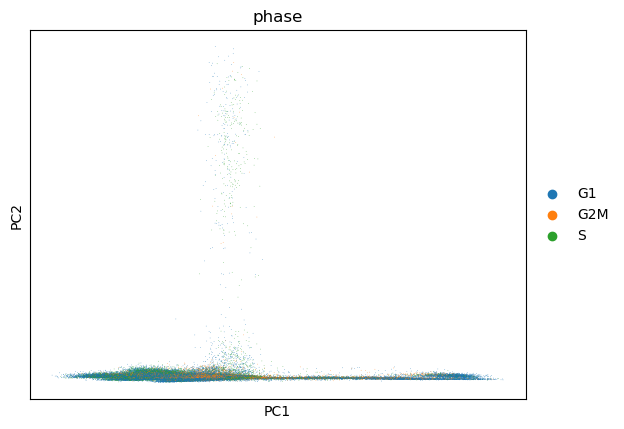

In [ ]:
# cell cycle phase
sc.pl.pca(adata, color='phase', use_raw=False, show=False)

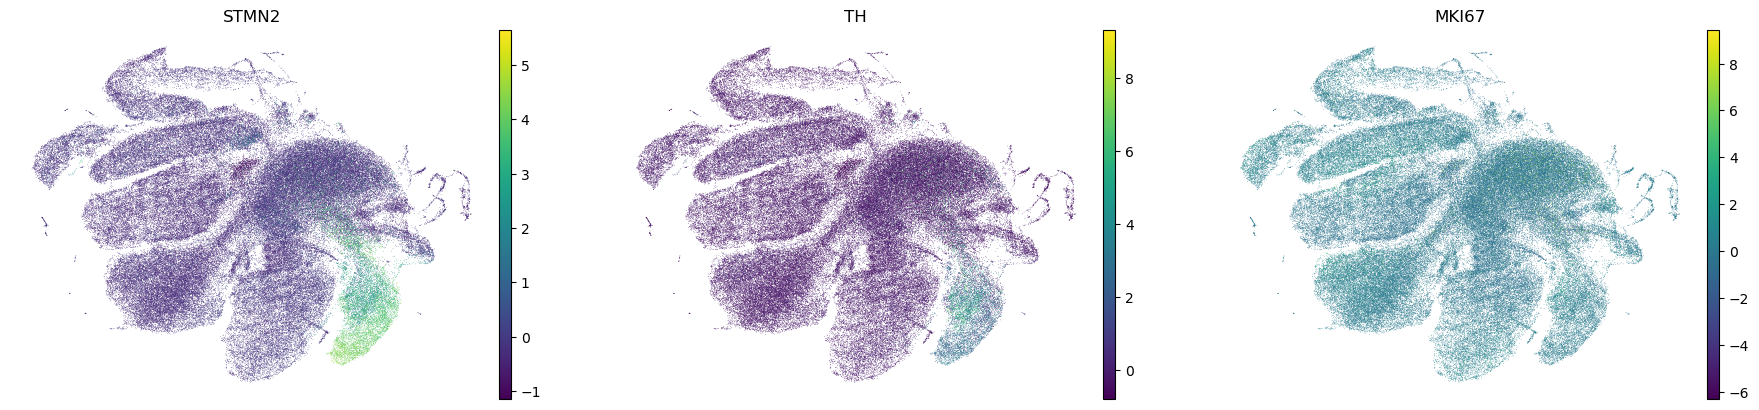

In [ ]:
sc.pl.umap(adata, color=['STMN2', 'TH', 'MKI67'], use_raw=False, frameon=False)